<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследуйте-модели" data-toc-modified-id="Исследуйте-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследуйте модели</a></span></li><li><span><a href="#Проверка-модели" data-toc-modified-id="Проверка-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка модели</a></span></li><li><span><a href="#(бонус)-Проверьте-модели-на-адекватность" data-toc-modified-id="(бонус)-Проверьте-модели-на-адекватность-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>(бонус) Проверьте модели на адекватность</a></span></li></ul></div>

# Рекомендация тарифов

**Задание**

>Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят **построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф**: «Смарт» или «Ультра».
<br><br>
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы ([из проекта «Статистический анализ данных»](https://github.com/chester519/yandex_praktikum_ds/tree/main/p03_determining_perspective_tariff_for_telecom_company "Github - Chester519"). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.
<br><br>
Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

**Описание данных**

Набор данных хранится в `datasets/users_behavior.csv`. Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

| столбец   | описание
| --------- | :--------
| calls     | количество звонков
| minutes   | суммарная длительность звонков в минутах
| messages  | количество sms-сообщени
| mb_used   | израсходованный интернет-трафик в Мб
| is_ultra  | каким тарифом пользовался в течение месяца<br>«Ультра» — 1, «Смарт» — 0

**Решение**

Решение задачи заключается в подборе лучшей модели машинного обучения для данного набора данных. Разобьем задачу на три части:

1. Загрузка и предобработка данных

Загрузим данные из CSV файла. Проверим имеются ли пропуски данных, а также какой тип у данных. Модели машинного обучения работают с числовыми данными. Также проведем анализ данных (признаков) на коррелируемость, иначе говоря на взаимное влияние. Признаки слишком сильно зависящие друг от друга не несут для модели новой информации, увеличивают время работы, а также могут привести к переобучению модели.

В конце этого этапа раздеим выборку на обучающую и тестовую. На первой выборке будем обучать набор моделей, а на второй только сделаем предсказания. Таким образом имитируем реальный процесс, когда модели получает данные, которые раньше не видела.
<hr>

2. Исследование моделей

На этом этапе используем ряд различных моделей и выберем из них лучшую. Задача модели максимально точно описать поведение объектов из набора данных, чтобы предсказать поведение других объектов. На предсказательную силу оказывают влияние следующие факторы:
- тип модели;
- гиперпараметры обучения;
- характер входных данных.

Меняя те или иные факторы, мы должны контролировать качество модели. Для этого используем метрику accuracy. Вариант модели с самой высокой метрикой примем как лучший.
<hr>

3. Проверка выбранной модели.

Используя лучшую модели получим предсказания на тестовой выборке и измерим качество этих предсказаний. Это значение и будет финальной оценкой качества.

## Загрузка данных

Импортируем необходимые библиотеки.

In [1]:
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Сохраним данные из файла CSV в переменную data и посмотрим на общую информацию о датасете.

In [2]:
data = pd.read_csv('datasets/users_behavior.csv')

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


В данных нет пропусков, а типы столбцов приведены к численным. Данные столбца *is_ultra* представленны целочисленным типом. Посмотрим на распределение значений *is_ultra*.

In [4]:
data['is_ultra'].value_counts(normalize=True).round(3)

0    0.694
1    0.306
Name: is_ultra, dtype: float64

Среди значений *is_ultra* 69.4% - 0 (тариф пользователя Смарт) и 30.6% - 1 (тариф пользователя Ультра).

Посчитаем корреляцию между признаками и построим диаграмму рассеяния.

,calls,minutes,messages,mb_used
calls,1.000000,0.982083,0.177385,0.286442
minutes,0.982083,1.000000,0.173110,0.280967
messages,0.177385,0.173110,1.000000,0.195721
mb_used,0.286442,0.280967,0.195721,1.000000


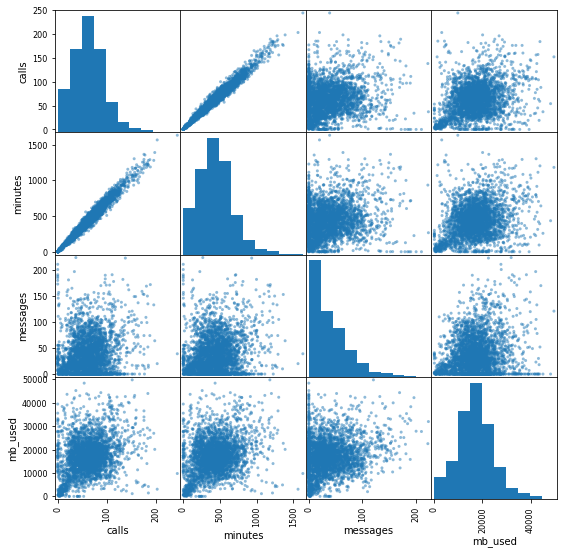

In [5]:
pd.plotting.scatter_matrix(data.drop('is_ultra', axis=1), figsize=(9, 9))

data.drop('is_ultra', axis=1).corr()

Между значениями минут и количества звонков существует сильная зависимость, коэффициент корреляции 0.98. В тарифах оператора существуют лимиты на минуты разговора, поэтому обучать модели будем на данных о минутах, а данные о количестве звонков уберем из выборки.

## Предобработка данных

Исходя из условия задачи за целевой признак возьмем значение *is_ultra*. Сохраним столбец *is_ultra*  в переменной target, а остальные признаки в переменной features. Не забудем убрать данные о количестве звонков.

In [6]:
features = data.drop(['is_ultra', 'calls'], axis=1)
target = data['is_ultra']

Разобьем датасет на обучающую (train) и тестовую (test) выборки в соотношении 8-2.

In [7]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.6, test_size=0.2, random_state=12345)

Проверим размеры полученных выборок.

In [8]:
print('Shapes\nTraining set: {}\nTesting set: {}'
      .format(features_train.shape, features_test.shape))

Shapes
Training set: (1928, 3)
Testing set: (643, 3)


Данные подготовленны для обучения и проверки моделей.

## Исследуйте модели

Будем обучать модели по трем алгоритмам обучения: решающее дерево (DecisionTreeClassifier), случайный лес (RandomForestClassifier) и логистическая регрессия (LogisticRegression). В словаре *models_accuracy* будем записывать результаты метрики Accuracy для лучшей модели.

In [9]:
models_accuracy = {}

Для алгоритма **Decision Tree** будем варьировать гиперпараметры: критерий выбора, минимальное число объектов во внутреннем узле, минимальное число объектов в листовом узле (нижнем) и глубина дерева. Выберем наилучшие гиперпараметры по метрике accuracy.

In [10]:
params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': range(2, 21, 4),
    'min_samples_leaf': range(1, 20, 4),
    'max_depth': range(1, 11, 2)
}

model = DecisionTreeClassifier(random_state=12345)
grid_dt = GridSearchCV(model, params, scoring='accuracy', cv=3)

grid_dt.fit(features_train, target_train)
    
models_accuracy['DT'] = grid_dt.best_score_
pd.DataFrame(grid_dt.cv_results_)[['param_criterion',
                                'param_max_depth',
                                'param_min_samples_split',
                                'param_min_samples_leaf',
                                'mean_test_score',
                                'rank_test_score']]\
    .sort_values('mean_test_score', ascending=False).head()

,param_criterion,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score,rank_test_score
84,gini,7,18,5,0.795638,1
80,gini,7,2,5,0.795122,2
81,gini,7,6,5,0.795122,2
82,gini,7,10,5,0.795122,2
83,gini,7,14,5,0.795122,2


Для алгоритма **Random Forest** будем варьировать гиперпараметры: количество оценщиков, глубину деревьев и минимальное количество объектов для разделения узла.

In [11]:
params = {
    'n_estimators': range(10, 51, 10),
    'max_depth': range(1, 11, 2),
    'min_samples_split': [2, 3, 5]
}

model = RandomForestClassifier(random_state=12345)
grid_rf = GridSearchCV(model, params, scoring='accuracy', cv=3)

grid_rf.fit(features_train, target_train)
    
models_accuracy['RFC'] = grid_rf.best_score_
pd.DataFrame(grid_rf.cv_results_)[['param_n_estimators',
                                'param_max_depth',
                                'param_min_samples_split',
                                'mean_test_score',
                                'rank_test_score']]\
    .sort_values('mean_test_score', ascending=False).head()

,param_n_estimators,param_max_depth,param_min_samples_split,mean_test_score,rank_test_score
68,40,9,3,0.803939,1
64,50,9,2,0.803421,2
69,50,9,3,0.802383,3
72,30,9,5,0.801864,4
67,30,9,3,0.801862,5


Для алгоритма **Logistic Regression** подберем алгоритм оптимизации.

In [12]:
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

model = LogisticRegression(random_state=12345)
grid_lr = GridSearchCV(model, params, scoring='accuracy', cv=3)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    grid_lr.fit(features_train, target_train)
    
models_accuracy['LR'] = grid_lr.best_score_
pd.DataFrame(grid_lr.cv_results_)[['param_solver', 'mean_test_score', 'rank_test_score']]

,param_solver,mean_test_score,rank_test_score
0,newton-cg,0.738071,1
1,lbfgs,0.717853,2
2,liblinear,0.705392,3
3,sag,0.700726,4
4,saga,0.700726,4


In [13]:
print('Accuracy:', pd.Series(models_accuracy).sort_values(ascending=False).round(4), sep='\n')

Accuracy:
RFC    0.8039
DT     0.7956
LR     0.7381
dtype: float64


Наибольший показатель accuracy был получен у модели с алгоритмом обучения Random Forest - 0.8039. Сохраним модель с подобранными гиперпараметрами в переменную *model*.

In [14]:
model = grid_rf.best_estimator_

## Проверка модели

Мы определили наилучший алгоритм и подобрали его параметры обучения. По умолчанию GridSearchCV имеет параметр refit=True, который отвечает за обучение лучшей модели с лучшими параметрами на всем наборе данных. Заново обучать выбранную модель не нужно. Теперь используем модель для предсказаний на тестовой выборке и посчитаем точность этих предсказаний. 

In [15]:
predictions = model.predict(features_test)
result = accuracy_score(target_test, predictions)

print('Accuracy на тестовой выборке: {:.4f}'.format(result))

Accuracy на тестовой выборке: 0.7963


Accuracy модели на тестовой выборке 0.7963, что больше требуемой заказчиком 0.75.

## (бонус) Проверьте модели на адекватность

Чтобы проверить полученную модель на адекватность, ее нужно с чем то сравнить. Создадим константную модель, которая будет осуществлять предсказания по заранее известному простому правилу.

In [16]:
from sklearn.dummy import DummyClassifier

In [17]:
dummy = DummyClassifier(strategy='most_frequent', random_state=12345)
dummy.fit(features_train, target_train)
dummy_score = dummy.score(features_test, target_test)
print('Accuracy константной модели:', round(dummy_score, 4))

Accuracy константной модели: 0.6952


Качество константной модели значительно ниже качества избранной модели. Из этого можно сделать вывод, что применение машинного обучения способно принести улучшить пользовательские рекомендации, следовательно и прибыль для компании.

В качестве дополнения, рассмотрим предсказания модели. Разделим датасет на две части по тарифу пользователя (*is_ultra*) и посчитаем точность прогноза на этих выборках.

In [18]:
smart = features[data['is_ultra']==0]
ultra = features[data['is_ultra']==1]
accuracy = []

In [19]:
for _features in [smart, ultra, features]:
    _target = target[_features.index]

    _predictions = model.predict(_features)
    accuracy.append(accuracy_score(_target, _predictions))

print('Accuracy предсказания тарифа:\nСмарт: {:.4f}\nУльтра: {:.4f}\nПо всей выборке: {:.4f}'.format(*accuracy))

Accuracy предсказания тарифа:
Смарт: 0.9726
Ультра: 0.5635
По всей выборке: 0.8472


Модель хорошо научилась предсказывать пользователей тарифа "Смарт" (97% точности), тогда как предсказания пользователей тарифа "Ультра" оказались не такими точными (56%). В целом по выборке точность обученной модели 84.7%.

Доля пользователей тарифа Ультра всего около 30%. Для увеличения точности предсказания этого тарифа можно увеличить долю пользователей "Ультра" в обучающей выборке.